In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.keras.models import Sequential


RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [4]:
#csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv"
df = pd.read_csv("formatted_output.csv", parse_dates=["timeOpen"])
df = df.sort_values('timeOpen')
df.head()

,timeOpen,timeClose,timeHigh,timeLow,priceOpen,priceHigh,priceLow,priceClose,volume
2512,2018-08-22 12:13:00,1.535030e+12,1.534950e+12,1.535020e+12,6486.25,6816.79,6310.11,6376.71,4.668110e+09
2511,2018-08-23 13:13:00,1.535110e+12,1.535110e+12,1.535030e+12,6371.34,6546.54,6371.34,6534.88,3.426180e+09
2510,2018-08-24 11:26:00,1.535200e+12,1.535200e+12,1.535120e+12,6551.52,6719.96,6498.64,6719.96,4.097820e+09
2509,2018-08-25 12:26:00,1.535280e+12,1.535210e+12,1.535230e+12,6719.95,6789.63,6700.96,6763.19,3.312600e+09
2508,2018-08-26 10:40:00,1.535370e+12,1.535290e+12,1.535310e+12,6754.64,6774.75,6620.75,6707.26,3.295500e+09


In [5]:
df.shape

(2513, 9)

Text(0, 0.5, 'Bitcoin Close Price (USD)')

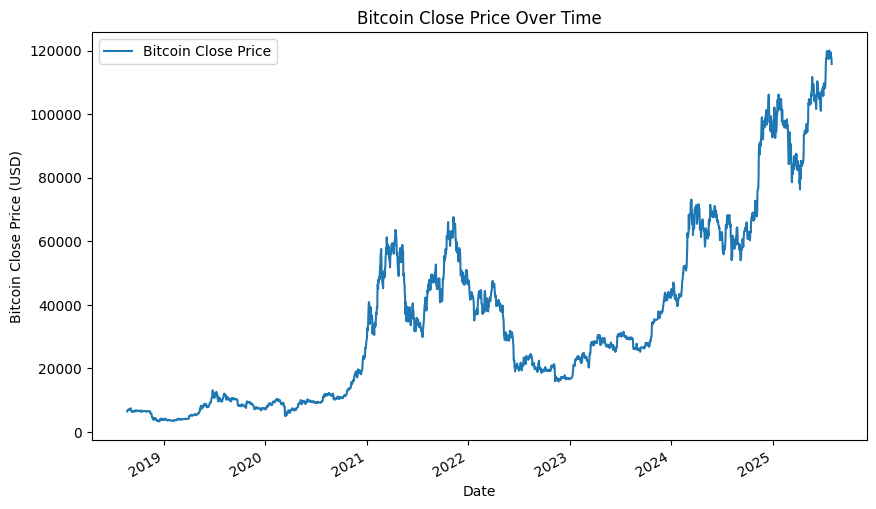

In [6]:
ax = df.plot(x='timeOpen', y='priceClose', kind='line', figsize=(10, 6), title='Bitcoin Close Price Over Time')
ax.set_xlabel("Date")
ax.legend(["Bitcoin Close Price"])
ax.set_ylabel("Bitcoin Close Price (USD)")

# Normalization #

In [8]:
scaler = MinMaxScaler()
close_price = df.priceClose.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close.shape

(2513, 1)

In [9]:
np.isnan(scaled_close).any()

False

In [10]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [11]:
scaled_close = scaled_close.reshape(-1, 1)

In [12]:
np.isnan(scaled_close).any()

False

# Processing #

In [33]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [34]:
X_train.shape


(2292, 99, 1)

In [35]:

X_test.shape

(121, 99, 1)

# Model

In [37]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1
# Build LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, X_train.shape[-1])),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])



Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0171 - mean_absolute_error: 0.0770 - val_loss: 0.0031 - val_mean_absolute_error: 0.0480
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 8.0650e-04 - mean_absolute_error: 0.0186 - val_loss: 0.0072 - val_mean_absolute_error: 0.0787
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 7.9570e-04 - mean_absolute_error: 0.0185 - val_loss: 0.0012 - val_mean_absolute_error: 0.0283
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 6.7884e-04 - mean_absolute_error: 0.0172 - val_loss: 0.0022 - val_mean_absolute_error: 0.0406
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 5.2277e-04 - mean_absolute_error: 0.0150 - val_loss: 0.0013 - val_mean_absolute_error: 0.0292
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 5.1931e-04 - mean_absolute_error: 0.0151 - val_loss: 0.0013 - val_mean_absolute_error: 0.0298
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 4.7073e-04 - mean_absolute

# Prediction

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step WARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001CE0978BA60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step


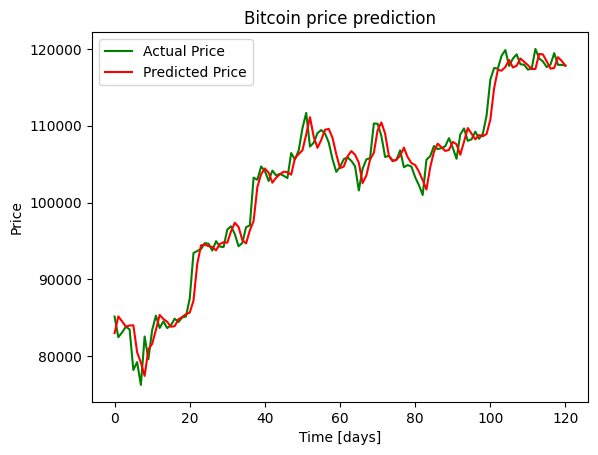

In [38]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
y_hat_inverse = scaler.inverse_transform(y_hat)

plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')

plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')

plt.show()

In [39]:
# Compute the MAE
mae = np.mean(np.abs(y_test_inverse - y_hat_inverse))
print(f'Mean Absolute Error: {mae}')
model.evaluate(X_test, y_test)

Mean Absolute Error: 1414.470091756198
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.9170e-04 - mean_absolute_error: 0.0124


[0.00026651384541764855, 0.012114475481212139]

In [41]:
model.save('best_bitcoin_model.keras')